In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [3]:
class ClassifierInterface:
    def train_model(self, X_train, y_train):
        pass


class RandomForest(ClassifierInterface):
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=300, max_features="auto")

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)


class SVM(ClassifierInterface):
    def __init__(self):
        self.model = SVC(gamma="auto", C=100, probability=True)

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

In [4]:
class AppDomainInterface:
    def __init__(self, AbstractClassifier, k, normal):
        pass

    def fit(self, X_train, no_of_labels):
        pass

    def predict(self, X_test, y_test):
        pass

    def predict_proba(self):
        pass

    def accuracy(self):
        pass

    def sensitivity(self):
        pass

    def specificity(self):
        pass

    def AUC_ROC(self):
        pass

    def _get_distance(self, a, b, sort=True):
        pass

    def _measure(self, test):
        pass


class AppDomainYEuc(AppDomainInterface):
    def __init__(self, classifier, k=5, normal=0.95):
        self.__classifier = classifier
        self.__k = k
        self.__normal = normal

    def fit(self, X_train, no_of_labels):
        self.__labels = no_of_labels
        self.__kNN_train_distance_sorted = self._get_distance(X_train, X_train, True)
        index = (
            round(len(self.__kNN_train_distance_sorted) * self.__normal) - 1
        )  # find max distance number's index
        self.__threshold = self.__kNN_train_distance_sorted[
            index
        ]  # max distance number

    def predict(self, X_test, y_test):
        dist_measure = self._measure(
            X_test
        )  # Measures if its within the distance model

        self.__inOrOut = (
            dist_measure <= 1
        )  # creates true or false list of whether it fits the model

        self.__y_test = y_test
        self.__y_pred = self.__classifier.model.predict(X_test)
        self.__y_pred[~self.__inOrOut] = 0  # makes all outliers false

        self.__predict_proba = self.__classifier.model.predict_proba(X_test)
        self.__predict_proba[~self.__inOrOut][0] = 1
        self.__predict_proba[~self.__inOrOut][1] = 0

        self.__accuracy = accuracy_score(y_test, self.__y_pred)
        self.__confusion_matrix = confusion_matrix(y_test, self.__y_pred)
        tn, fp, fn, tp = self.__confusion_matrix.ravel()
        self.__sensitivity = tp / (tp + fn)
        self.__specificity = tn / (tn + fp)

        self.__AUC_ROC = roc_auc_score(y_test, self.__predict_proba[:, 1])

        print("Accuracy:", self.__accuracy)

        return self.__y_pred

    def predict_proba(self):
        return self.__predict_proba

    def accuracy(self):
        return self.__accuracy

    def sensitivity(self):
        return self.__sensitivity

    def specificity(self):
        return self.__specificity

    def AUC_ROC(self):
        return self.__AUC_ROC

    def AUC_random(self):
        return 0.5 * (self.__sensitivity + self.__specificity)

    def AUC_max(self):
        return 1 - ((1 - self.__sensitivity) * (1 - self.__specificity))

    def show_ROC_curve(self):
        fpr, tpr, thresh = roc_curve(
            self.__y_test, self.__predict_proba[:, 1], pos_label=1
        )

        random_probs = [0 for i in range(len(self.__y_test))]
        p_fpr, p_tpr, p_thresh = roc_curve(self.__y_test, random_probs, pos_label=1)

        plt.style.use("seaborn-whitegrid")
        plt.plot(fpr, tpr, linestyle="--", color="blue", label="Y Euclidean")
        plt.plot(p_fpr, p_tpr, linestyle="--", color="green")

        plt.title("ROC curve")
        plt.xlabel("False Positive rate")
        plt.ylabel("True Positive rate")

        plt.tight_layout()
        path_output = os.path.join(
            "..", "results", f"ROC_Y_Euclidean_{type(self.__classifier).__name__}.pdf"
        )
        plt.savefig(path_output, dpi=300)

    def _get_distance(self, XA, XB, sort=True):
        distance = cdist(XA, XB, metric="euclidean")
        distance.sort()

        kNN_distance = np.mean(distance[:, : self.__k + 1], axis=1)
        if sort:
            kNN_distance.sort()
        return kNN_distance

    def _measure(self, X_test):
        self.__kNN_train_test_distance = self._get_distance(X_test, X_train, False)

        measure = self.__kNN_train_test_distance / self.__threshold
        return measure

In [5]:
files_path = os.path.join("..", "data", "maccs")

dataset_files = [os.path.join(files_path, file) for file in os.listdir(files_path)]

data_path = dataset_files[0]
print(f"Read from: {data_path}")

df = pd.read_csv(data_path)
df.head()

Read from: ../data/maccs/Ames_MACCS.csv


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x158,x159,x160,x161,x162,x163,x164,x165,x166,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,2.0,1.0,42.0,6.0,44.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,6.0,2.0,6.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,4.0,0.0,6.0,3.0,6.0,0.0,1.0


In [6]:
SEED = 1234

y = df["y"].to_numpy()
X = df.drop(["y"], axis=1).to_numpy()

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
print(X_train.shape, X_test.shape)

(6512, 166) (6512,)
(5209, 166) (1303, 166)


In [7]:
model1 = RandomForest()
model1.train_model(X_train, y_train)

model2 = SVM()
model2.train_model(X_train, y_train)

In [8]:
ad = AppDomainYEuc(model1)
ad.fit(X_train, len(y_train.shape))
ad.predict(X_test, y_test)

print(f"Sensitivity: {ad.sensitivity()}")
print(f"Specificity: {ad.specificity()}")
print(f"AUC ROC: {ad.AUC_ROC()}")

Accuracy: 0.8004604758250192
Sensitivity: 0.7635327635327636
Specificity: 0.8435940099833611
AUC ROC: 0.881287597593754


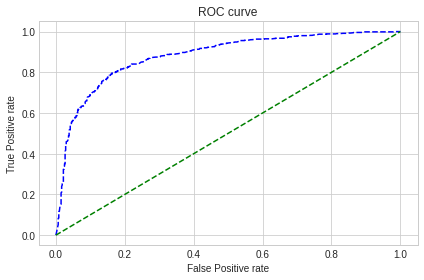

In [9]:
ad.show_ROC_curve()

In [10]:
ad = AppDomainYEuc(model2)
ad.fit(X_train, len(y_train.shape))
ad.predict(X_test, y_test)

print(f"Sensitivity: {ad.sensitivity()}")
print(f"Specificity: {ad.specificity()}")
print(f"AUC ROC: {ad.AUC_ROC()}")

Accuracy: 0.7735993860322333
Sensitivity: 0.7507122507122507
Specificity: 0.800332778702163
AUC ROC: 0.841268825461837


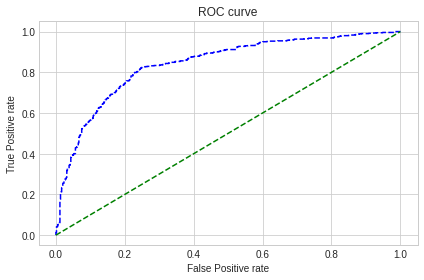

In [11]:
ad.show_ROC_curve()